- blog : http://francescopochetti.com/fast-neural-style-transfer-sagemaker-deployment/#Saving_the_model_to_disk_and_uploading_to_S3
- source : https://github.com/gabrielelanaro/ml-prototypes.git

# Bring your own Model

### 1. PyTorch로 개발된 다른 모델을 다운받는다.

- Style Transfer 실행하는 모델  
![](./styletransfer.png)

In [ ]:
!git clone https://github.com/gabrielelanaro/ml-prototypes.git

In [1]:
styles = ['kandinsky','picasso','vangogh']

In [2]:
!ls ml-prototypes/prototypes/styletransfer/fast_neural_st/{styles[0]}/

model.pth  model.tar.gz


* model.tar.gz의 구조 살펴보기

In [3]:
!tar zvft ml-prototypes/prototypes/styletransfer/fast_neural_st/{styles[0]}/model.tar.gz 

drw-r--r-- 0/0               0 1970-01-01 00:00 models/
-rw-rw-r-- ec2-user/ec2-user 6729038 2019-08-26 16:23 model.pth


- model.pth 파일을 tarball로 생성한 파일임. 
- 아래와 같은 스크립트로 생성 

```python
import tarfile
style = "vangogh" # or whatever other style
with tarfile.open(f'./{style}/model.tar.gz', 'w:gz') as f:
    t = tarfile.TarInfo('models')
    t.type = tarfile.DIRTYPE
    f.addfile(t)
    f.add(f'{style}/model.pth', arcname='model.pth')
 
```


### 2. Upload model.tar.gz into S3

In [4]:
import sagemaker as SM
SM_session = SM.Session()
bucket = "leonkang-datalake-nv"
model_artifacts = []

for style in styles:
    path = 'ml-prototypes/prototypes/styletransfer/fast_neural_st/' + style
    prefix = 'style-transfer/' + style
    model_artifact = SM_session.upload_data(path=f'./{path}/model.tar.gz', bucket=bucket, key_prefix=prefix)
    model_artifacts.append(model_artifact)

In [5]:
model_artifacts

['s3://leonkang-datalake-nv/style-transfer/kandinsky/model.tar.gz',
 's3://leonkang-datalake-nv/style-transfer/picasso/model.tar.gz',
 's3://leonkang-datalake-nv/style-transfer/vangogh/model.tar.gz']

### 3. PyTorch Model 생성

In [6]:
model_artifact = model_artifacts[0]

In [7]:
from sagemaker.pytorch import PyTorchModel
role = SM.get_execution_role()
 
from sagemaker.predictor import RealTimePredictor, json_deserializer
 
class ImagePredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super().__init__(endpoint_name, sagemaker_session=sagemaker_session, serializer=None, 
                         deserializer=json_deserializer, content_type='image/jpeg')
 
pytorch_model = PyTorchModel(model_data=model_artifact, role=role,framework_version='1.0.0', name=style,
                             entry_point='sagemaker_inference.py', source_dir = 'src_dir',
                             predictor_cls=ImagePredictor)


In [8]:
import boto3
SM.predictor.

In [80]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Using already existing model: vangogh


--------------------------------------------------------------------------------------!

### 4. Inference 

In [17]:
import base64
import io
import matplotlib.pyplot as plt
from PIL import Image

#### 4-1. deploy에서 사용한 predictor 호출

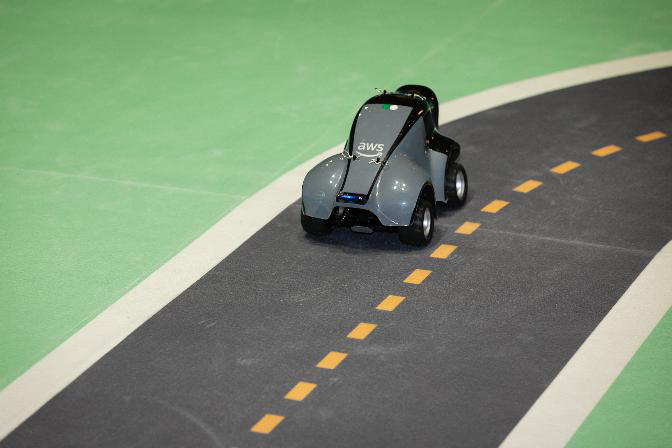

In [71]:
Image.open('deepracer.jpg')

In [73]:
resp41 = predictor.predict(open("deepracer.jpg", mode='rb'))

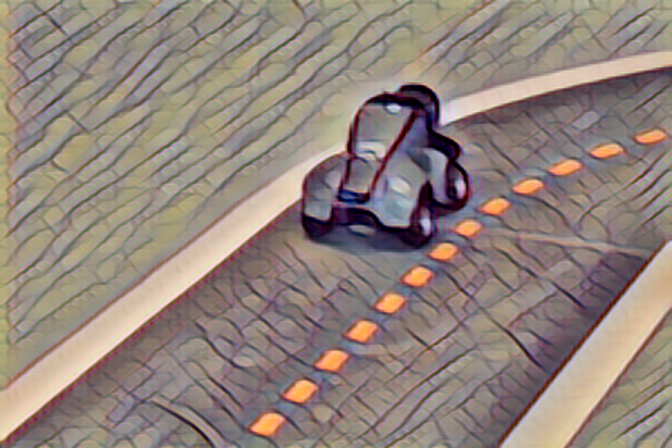

In [74]:
img_vangogh41 = base64.b64decode(resp41['prediction'])
Image.open(io.BytesIO(img_vangogh41))

#### 4-2. SageMaker api로부터 Endpoint에 대한 predictor 생성하여 호출

In [35]:
import boto3, json
from sagemaker.predictor import json_serializer, json_deserializer, RealTimePredictor
# from sagemaker_inference import content_types, decoder
# from sagemaker.content_types import CONTENT_TYPE_CSV, CONTENT_TYPE_JSON
from sagemaker import Session
sess = Session()

endpoint_name = 'vangogh'
runtime = boto3.Session().client('runtime.sagemaker')
my_endpoint = endpoint_name

In [36]:
my_predictor = RealTimePredictor(endpoint=my_endpoint, sagemaker_session=sess, serializer=json_serializer, deserializer=json_deserializer,
                                 content_type = 'application/x-image')

In [76]:
resp42 = my_predictor.predict(open("deepracer.jpg", mode='rb'))

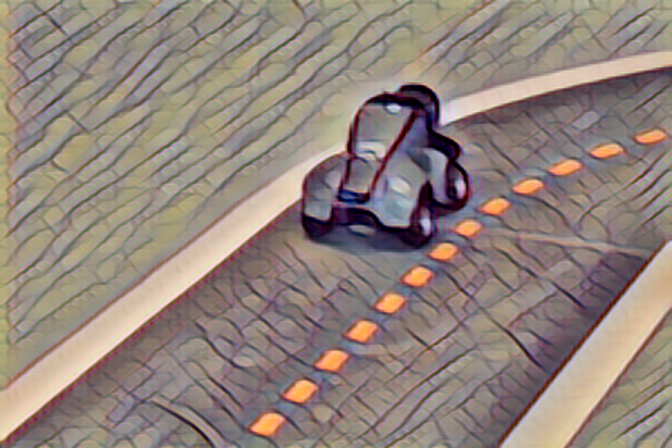

In [78]:
img_vangogh42 = base64.b64decode(resp42['prediction'])
Image.open(io.BytesIO(img_vangogh42))

### 4-3. boto3 sdk로부터 invoke_endpoint 호출

In [79]:
import boto3

endpoint_name = "vangogh"                
runtime = boto3.Session().client(service_name='sagemaker-runtime',region_name='us-east-1')

In [94]:
img = open("deepracer.jpg", mode='rb')
# payload = bytearray(img)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/x-image', Body=img)
resp43 = response.get('Body').read().decode()

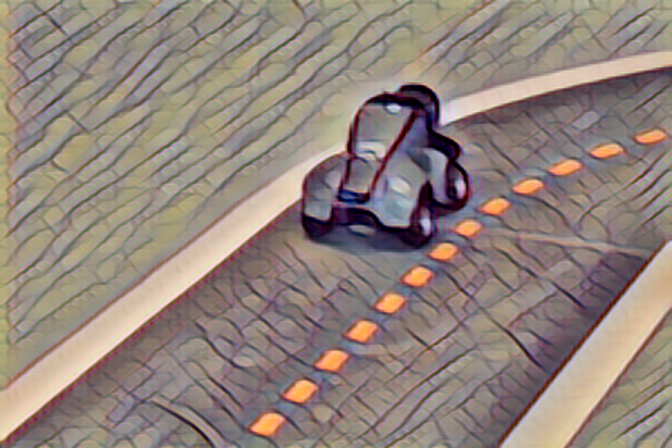

In [100]:
img_vangogh43 = base64.b64decode(json.loads(resp43)['prediction'])
Image.open(io.BytesIO(img_vangogh43))

# Mutlti model dployment

작업중

In [ ]:

with open(file_name, 'rb') as f:

payload = f.read()

payload = bytearray(payload)

response = runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/x-image', Body=payload)

#response = runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/x-npy', Body=payload)

​

In [84]:
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(list(funcs), key=key): x = f(x, **kwargs)
    return x

class Transform(): _order=0
        
class MakeRGB(Transform):
    def __call__(self, item): return {k: v.convert('RGB') for k, v in item.items()}

class ResizeFixed(Transform):
    _order=10
    def __init__(self, size):
        if isinstance(size,int): size=(size,size)
        self.size = size
        
    def __call__(self, item): return {k: v.resize(self.size, PIL.Image.BILINEAR) for k, v in item.items()}

class ToByteTensor(Transform):
    _order=20
    def to_byte_tensor(self, item):
        res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
        w,h = item.size
        return res.view(h,w,-1).permute(2,0,1)
    
    def __call__(self, item): return {k: self.to_byte_tensor(v) for k, v in item.items()}


class ToFloatTensor(Transform):
    _order=30
    def to_float_tensor(self, item): return item.float().div_(255.)
    
    def __call__(self, item): return {k: self.to_float_tensor(v) for k, v in item.items()}
    
class Normalize(Transform):
    _order=40
    def __init__(self, stats, p=None):
        self.mean = torch.as_tensor(stats[0] , dtype=torch.float32)
        self.std = torch.as_tensor(stats[1] , dtype=torch.float32)
        self.p = p
    
    def normalize(self, item): return item.sub_(self.mean[:, None, None]).div_(self.std[:, None, None])
    def pad(self, item): return nn.functional.pad(item[None], pad=(self.p,self.p,self.p,self.p), mode='replicate').squeeze(0)
    
    def __call__(self, item): 
        if self.p is not None: return {k: self.pad(self.normalize(v)) for k, v in item.items()}
        else: return {k: self.normalize(v) for k, v in item.items()}

In [105]:
# img = PIL.Image.open(io.BytesIO(request_body))
item = {'input': img}

In [106]:
x = MakeRGB()

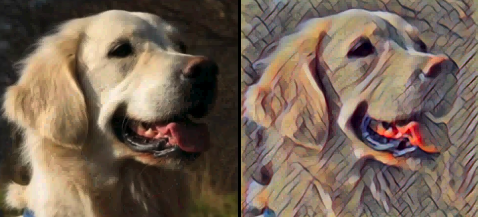

In [108]:
x(item)['input']

In [67]:
import imp

In [71]:
imp.reload(TransformerNet)

<module 'TransformerNet' from '/home/ec2-user/SageMaker/Torch_model_invoke/TransformerNet.py'>

In [35]:
import torch

In [60]:
import TransformerNet as TN

In [72]:
dir(TransformerNet)

['ConvLayer',
 'ResidualBlock',
 'TransformerNet',
 'UpsampleConvLayer',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'torch']

In [73]:
TransformerNet.TransformerNet()

TransformerNet(
  (conv1): ConvLayer(
    (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
    (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  )
  (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  )
  (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (in3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (res1): ResidualBlock(
    (conv1): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (in1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (

In [57]:
TransformerNet.mymodel()

AttributeError: module 'TransformerNet' has no attribute 'mymodel'

In [56]:
dir(TransformerNet)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__']